# Data preprocressing 

In [1]:
!pip install pydicom
!pip install pathlib

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !pip install kaggle
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [00:33<00:00, 179MB/s]
100% 3.66G/3.66G [00:33<00:00, 118MB/s]


In [6]:
!for z in *.zip; do unzip "$z"; done
!ls 

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_train_images/d539e101-5662-445c-9f6a-381e674f0aed.dcm  
  inflating: stage_2_train_images/d53cee27-787e-4136-aaf6-03bcff985ac9.dcm  
  inflating: stage_2_train_images/d53ebae4-9b96-4a05-b066-4635d52e3ac2.dcm  
  inflating: stage_2_train_images/d54150ef-1739-4002-aaef-e4e8441038b1.dcm  
  inflating: stage_2_train_images/d54240c5-1375-42c8-85b5-e77968f6befc.dcm  
  inflating: stage_2_trai

In [7]:
labels = pd.read_csv("stage_2_train_labels.csv")

In [22]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [9]:
labels = labels.drop_duplicates("patientId")

In [10]:
labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [11]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed")

Exemple de imagini din dataset:

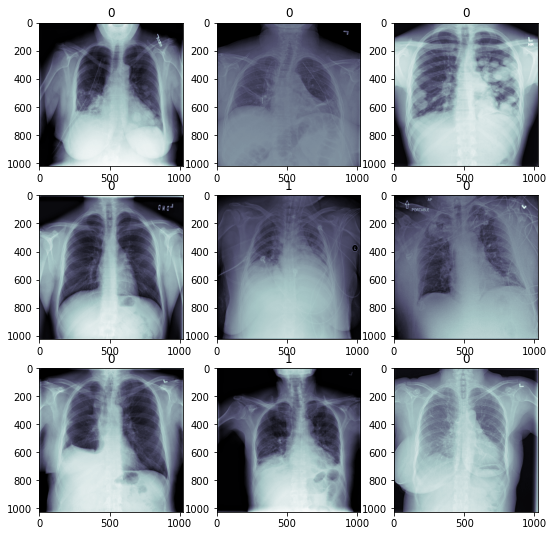

In [24]:
fig, axis = plt.subplots(3, 3, figsize = (9, 9))
c = 0
for i in range(3):
  for j in range(3):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array

    label = labels["Target"].iloc[c]

    axis[i][j].imshow(dcm, cmap = "bone")
    axis[i][j].set_title(label)
    c += 1



*   Împărțirea imaginilor în două foldere, de antrenare și testare, iar fiecare e împărțit în alte două: 1 pentru pacienții cu pneumonie și 0 pentru cei sănătoși.
*   Normalizarea array-urilor pentru a avea valori în [0,1]
*   Resize din 1024x1024 în 224x224
*   Am redus dimensiunea dataset-ului la 12.000 imagini pentru antrenare si 2000 pentru testare



In [13]:
from unicodedata import normalize
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array / 255  # normalizare

    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)  # initial aveau 1024x1024

    label = labels.Target.iloc[c]

    train_or_val = "train" if c < 10000 else "val" 
    if c == 12000:
      break

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents = True, exist_ok = True)
    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
      sums += np.sum(dcm_array) / normalizer
      sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [14]:
mean = sums / 10000
std = np.sqrt((sums_squared / 10000) - mean**2)

In [15]:
mean, std

(0.49075656887754965, 0.2489243965912755)

# Data Augmentation

In [ ]:
! pip install torchmetrics
! pip install pytorch_lightning

In [17]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [19]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std),
                                       transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
                                       transforms.RandomResizedCrop((224, 224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std),
])

In [20]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train", loader = load_file, extensions = "npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Processed/val", loader = load_file, extensions = "npy", transform = val_transforms)


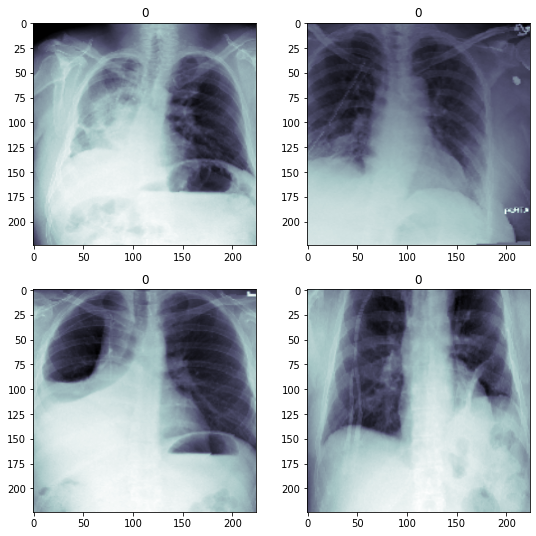

In [21]:
fig, axis = plt.subplots(2, 2, figsize = (9, 9))
for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0, 10000)
    x_ray, label = train_dataset[random_index]
    axis[i][j].imshow(x_ray[0], cmap = "bone")
    axis[i][j].set_title(label)

In [25]:
batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [26]:
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([7721, 2279]))

Dataset-ul este inegal, fiind de aproximativ 3 ori mai multe imagini fără pneumonie, decăt cu pneumonie.\
Vom compara rezultate după folosirea weighted_loss cu rezultatele antrenării normale.

# DenseNet


In [ ]:
torchvision.models.densenet201()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
class PneumoniaModel2(pl.LightningModule):

  def __init__(self, weight = 1):
    super().__init__()
    
    self.model = torchvision.models.densenet201()
    self.model.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.classifier = torch.nn.Linear(in_features=1920, out_features=1, bias=True)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight]))

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:,0]
    loss = self.loss_fn(pred, label)

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

    return loss

  def training_epoch_end(self, outs):
    self.log("Train ACC", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:,0]
    loss = self.loss_fn(pred, label)

    self.log("Val Loss", loss)
    self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

    return loss

  def validation_epoch_end(self, outs):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
    return [self.optimizer]



In [30]:
model = PneumoniaModel2(weight = 3)

In [31]:
checkpoint_callback1 = ModelCheckpoint(
    monitor='Val ACC',
    dirpath='./weights_densenet201',
    save_top_k=10,
    mode='max'
)

In [32]:
batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [33]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | DenseNet          | 18.1 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.354    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumoniaModel2.load_from_checkpoint("weights_densenet201/epoch=6-step=4375.ckpt")
model.eval()
model.to(device);

In [38]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2000 [00:00<?, ?it/s]

In [36]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}") # epoch=9-step=6250.ckpt

Val Accuracy: 0.7145000100135803
Val Precision: 0.3955135643482208
Val Recall: 0.8502538204193115
Confusion Matrix:
 tensor([[1094,  512],
        [  59,  335]])
Confusion Matrix 2:
 tensor([[ 568, 1038],
        [  15,  379]])


In [39]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}") # epoch=8-step=5625.ckpt

Val Accuracy: 0.7214999794960022
Val Precision: 0.40239521861076355
Val Recall: 0.8527919054031372
Confusion Matrix:
 tensor([[1107,  499],
        [  58,  336]])
Confusion Matrix 2:
 tensor([[685, 921],
        [ 15, 379]])


In [44]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}") # epoch=7-step=5000.ckpt

Val Accuracy: 0.7245000004768372
Val Precision: 0.39974457025527954
Val Recall: 0.7944162487983704
Confusion Matrix:
 tensor([[1136,  470],
        [  81,  313]])
Confusion Matrix 2:
 tensor([[835, 771],
        [ 28, 366]])


In [47]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}") # epoch=6-step=4375.ckpt

Val Accuracy: 0.7985000014305115
Val Precision: 0.49241146445274353
Val Recall: 0.7411167621612549
Confusion Matrix:
 tensor([[1305,  301],
        [ 102,  292]])
Confusion Matrix 2:
 tensor([[982, 624],
        [ 40, 354]])
